In [264]:
from tests.heat_eqn.simulate_multidim import get_fourier_eigenstates

eigenstates = get_fourier_eigenstates(np.array([1,2]), np.array([True,True]))

gs,c,freq = next(eigenstates)
print(np.linalg.norm(gs),
c,
freq,
np.abs(np.sqrt(c)-np.linalg.norm(gs)))

2.8284271247461903 8.0 [0 0] 0.0


In [189]:
from tests.heat_eqn.input_handler import ExperimentInput, generate_input_file
import numpy as np
alpha=0.8
triangle_f0 = np.zeros(Nx:=2**6,np.float64)
triangle_f0[0:Nx//2] = np.linspace(1.0,2.0,Nx//2,endpoint=False)
triangle_f0[Nx//2:Nx] = np.linspace(2.0,1.0,Nx//2,endpoint=False)
# plt.plot(np.arange(Nx),triangle_f0)
inputs = [ExperimentInput(1,alpha,0.1,1.0,[2,4,6],f'6 qubit square wave {alpha=:0.2}', '', n:=6, 0.1, False, np.ones(2**n,np.float64)),
          ExperimentInput(1,alpha,0.1,1.0,[2,4,6],f'6 qubit triangle wave {alpha=:0.2}', '', n:=6, 0.1, True, triangle_f0)]
generate_input_file(inputs, 'tests/heat_eqn/', f'{alpha:0.2}_alpha', f'tests/heat_eqn/{alpha:0.2}_alpha')

In [266]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from tests.heat_eqn.save_experiments import ExperimentData
%matplotlib inline

def get_expt_data(f:h5py.File) -> ExperimentData:
    return ExperimentData(f.attrs['dx'], 
                               f.attrs['L'], 
                               dt:=f.attrs['dt'],
                               f.attrs['Nt']*dt,
                               f.attrs['periodic_bc_flag'],
                               f['statevectors/f0'][:],
                               f['statevectors/qite_sols'][:],
                               f['statevectors/analytical_sol'][:],
                               f['D_list'][:],
                               np.array([f['stats/fidelity'][:],
                                         f['stats/log_norm_ratio'][:],
                                         f['stats/mean_square_error'][:]])
                               )

hdf5_file = 'data/heat_eqn/alpha=0.8/6 qubit square wave alpha=0.8.hdf5'

with h5py.File(hdf5_file) as f:
    alpha = f.attrs['alpha']
    expt_data = get_expt_data(f)

In [267]:
Nx = np.int32(np.ceil((expt_data.L-expt_data.dx)/expt_data.dx))
type(expt_data.D_list)

numpy.ndarray

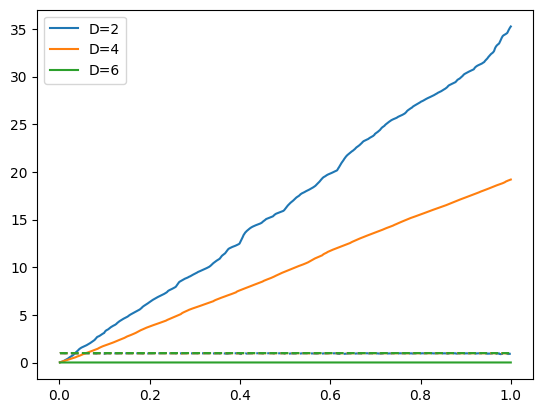

In [268]:
from matplotlib import colormaps

cmap = colormaps.get_cmap('coolwarm').reversed()
Nt = np.int32(np.ceil(expt_data.T/expt_data.dt))
Nx = np.int32(np.ceil((expt_data.L-expt_data.dx)/expt_data.dx))
an_norms = np.zeros(Nt,np.float64)
ex_norms = np.zeros((expt_data.D_list.shape[0],Nt), np.float64)

cPrimes = np.zeros((expt_data.D_list.shape[0], Nt), np.float64)

for ti,t in enumerate(np.arange(Nt)*expt_data.dt):
    an_norms[ti] = np.linalg.norm(expt_data.analytical_sol[ti])

for Di,D in enumerate(expt_data.D_list):
    for ti,t in enumerate(np.arange(Nt)*expt_data.dt):
        ex_norms[Di][ti] = np.linalg.norm(expt_data.qite_sols[Di][ti])
        if ti == 0:
            cPrimes[Di][ti] = ex_norms[Di][ti] / np.linalg.norm(expt_data.f0)
        else:
            cPrimes[Di][ti] = ex_norms[Di][ti] / ex_norms[Di][ti-1]
        
for Di,D in enumerate(expt_data.D_list):
    l, = plt.plot(times:=np.arange(1,Nt+1)*expt_data.dt, np.log(an_norms/ex_norms[Di]),label=f'D={D}')
    # plt.plot(times, ex_norms[Di],color=l.get_color(),linestyle='dotted')
    # plt.plot(times, an_norms,color='black',linestyle='dashdot')
    # plt.plot(times, np.exp(-expt_data.stat_data[1][Di][1:])*an_norms,color=l.get_color(),linestyle='--')
    plt.plot(times, cPrimes[Di], linestyle='--', color=l.get_color(),)

# plt.ylim([0.8,1.2])
plt.legend()
plt.show()

In [269]:
np.array([an_norms[0],*(ex_norms[:,0])])

array([8.10442128, 7.87831889, 7.88048113, 7.97997494])

In [278]:
(np.pi/expt_data.L)

0.483321946706122

K=100, lambda0=0.18688008333423634
K=50, lambda0=0.18688008333423634
K=20, lambda0=0.18688008333423634
K=1, lambda0=0.18688008333423634


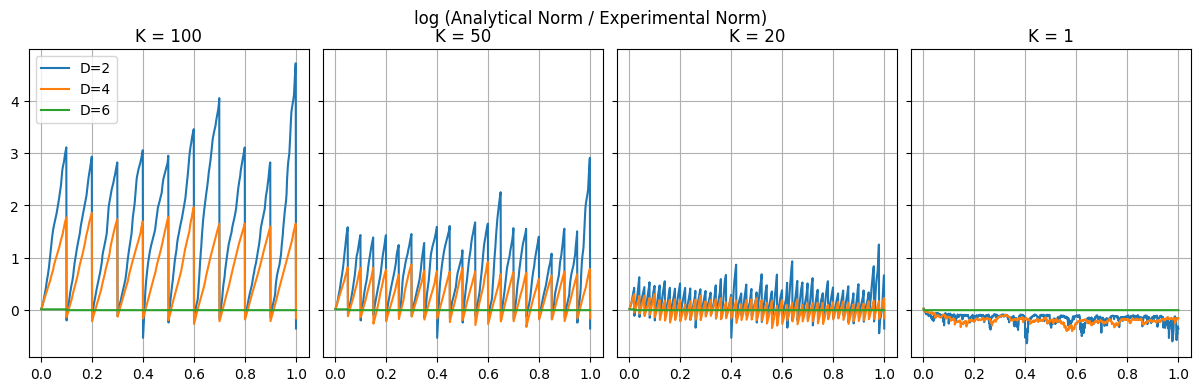

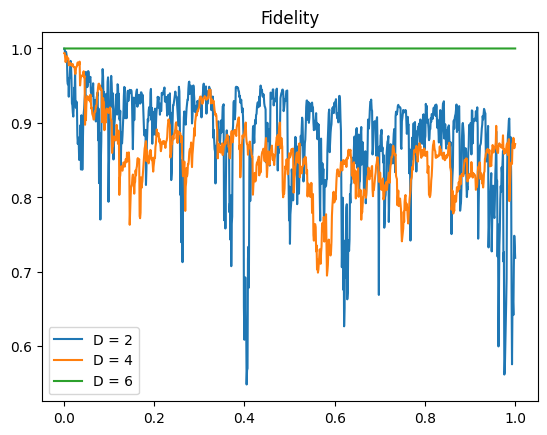

In [274]:
def get_CPsis(K:int) -> np.ndarray[float]:
    CPsis = np.zeros((expt_data.D_list.shape[0], Nt),np.float64)

    X = np.arange(1,Nx+1)*expt_data.dx
    gs = np.sin(np.pi*X/expt_data.L)
    gs /= np.linalg.norm(gs)

    braket_gs_f0 = np.dot(gs, expt_data.f0)/np.linalg.norm(expt_data.f0)
    lambda0 = alpha*(np.pi/expt_data.L)**2
    print(f'{K=}, {lambda0=}')

    for Di,D in enumerate(expt_data.D_list):
        for ti,t in enumerate(times):
            if ti == 0:
                CPsis[Di][ti] = cPrimes[Di][0]
            elif (ti+1)%K != 0:
                CPsis[Di][ti] = CPsis[Di][ti-1]*cPrimes[Di][ti]
            else:
                CPsis[Di][ti] = braket_gs_f0/np.dot(gs, expt_data.qite_sols[Di][ti])*np.linalg.norm(expt_data.qite_sols[Di][ti])*np.exp(-lambda0*t)

    CPsis *= np.linalg.norm(expt_data.f0)
    return CPsis


Ks = [Nt//10, Nt//20, Nt//50, 1]
fig,axs = plt.subplots(1,len(Ks),sharex=True,sharey=True,figsize=(15,4))
for Ki,K in enumerate(Ks):
    CPsis = get_CPsis(K)
    for Di,D in enumerate(expt_data.D_list):
        # l, = axs[Ki].plot(times,np.exp(-expt_data.stat_data[1][Di][1:]),label=f'D={D}')
        # l, = axs[Ki].plot(times,-np.log(ex_norms[Di]/an_norms),label=f'D={D}')
        axs[Ki].plot(times,-np.log(CPsis[Di]/an_norms), label=f'{D=}')#linestyle='--', color=l.get_color())

        # axs[1].plot(times, expt_data.stat_data[0][Di][1:])
        axs[Ki].set_title(f'{K = }')
        axs[Ki].grid(True)
fig.suptitle('log (Analytical Norm / Experimental Norm)')
# axs[1].set_title('Fidelity')
axs[0].legend()
fig.subplots_adjust(wspace=0.05)
plt.show()

for Di,D in enumerate(expt_data.D_list):
    plt.plot(times, expt_data.stat_data[0][Di][1:],label=f'{D = }')
plt.title('Fidelity')
plt.legend()
plt.show()

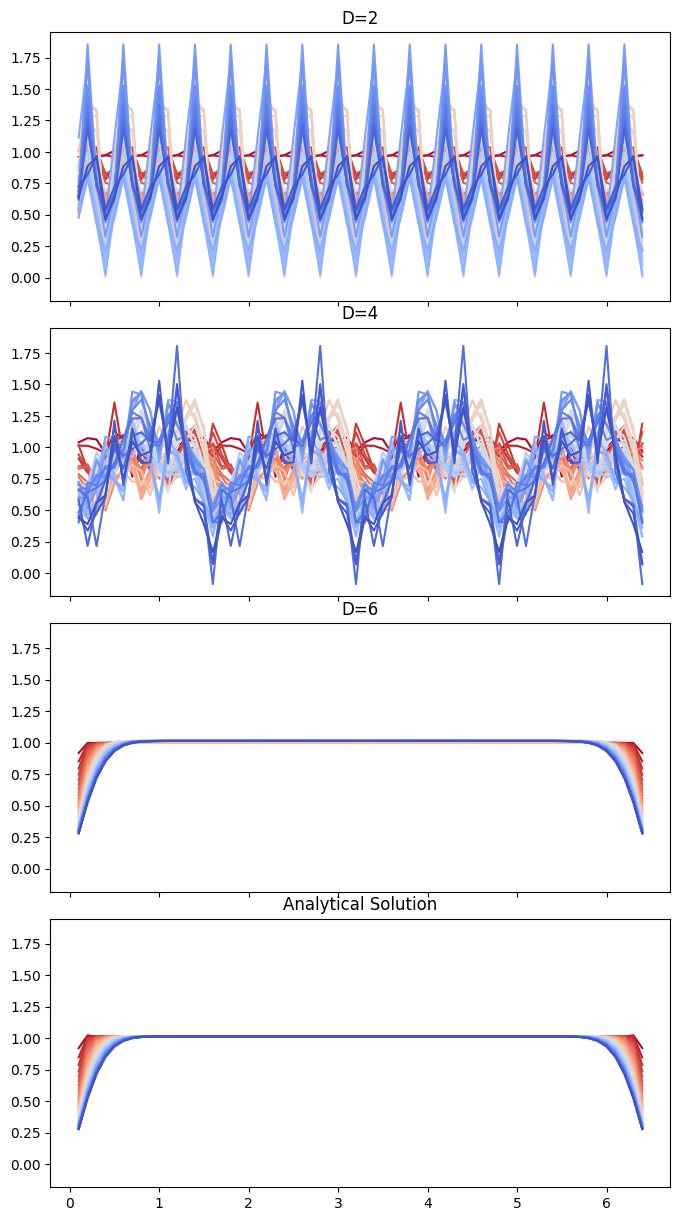

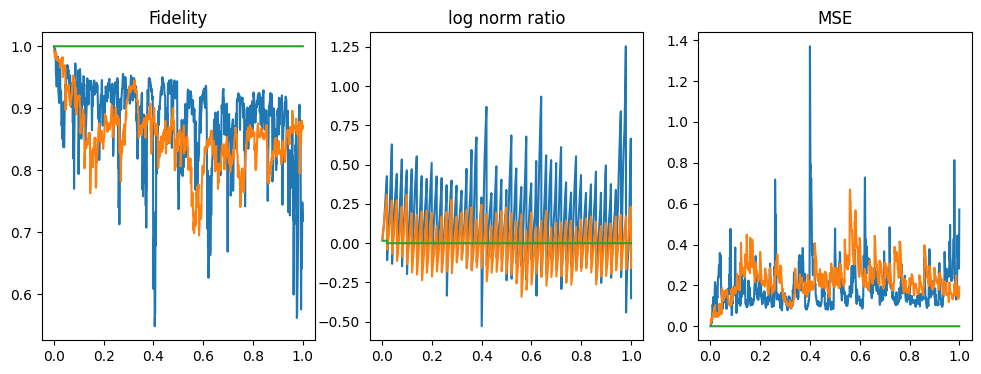

In [271]:
K = 20
CPsis = get_CPsis(K)
X = np.arange(1,Nx+1)*expt_data.dx

norm_qite_sols = expt_data.qite_sols.copy()
for Di,D in enumerate(expt_data.D_list):
    for ti,t in enumerate(times):
        norm_qite_sols[Di][ti] *= CPsis[Di][ti]/np.linalg.norm(norm_qite_sols[Di][ti])

fig,axs = plt.subplots(expt_data.D_list.shape[0]+1,1,sharex=True,sharey=True,figsize=(8,15))
for Di,D in enumerate(expt_data.D_list):
    for ti,t in enumerate(times[::Nt//50]):
        axs[Di].plot(X, norm_qite_sols[Di][ti], color=cmap(t/expt_data.T))
    axs[Di].set_title(f'{D=}')
for ti,t in enumerate(times[::Nt//50]):
    axs[-1].plot(X,expt_data.analytical_sol[ti],color=cmap(t/expt_data.T))
axs[-1].set_title('Analytical Solution')
fig.subplots_adjust(hspace=0.1)
plt.show()

fig,axs = plt.subplots(1,3,sharex=True,figsize=(12,4))
for Di,D in enumerate(expt_data.D_list):
    axs[0].plot(times, expt_data.stat_data[0][Di][1:],label=f'{D=}')
    axs[1].plot(times, np.log(an_norms/CPsis[Di]),label=f'{D=}')
    axs[2].plot(times, np.linalg.norm(norm_qite_sols[Di]-expt_data.analytical_sol,axis=1)**2/Nx,label=f'{D=}')

axs[0].set_title('Fidelity')
axs[1].set_title('log norm ratio')
axs[2].set_title('MSE')
plt.show()

In [93]:
print(CPsis[:][0:5])

[[0.9999669  0.99993389 0.99990055 ... 6.54793539 6.54700582 6.55791795]
 [0.99996686 0.99993371 0.99990068 ... 6.74332665 6.74261745 6.76113818]
 [0.99996875 0.99993756 0.99990643 ... 6.2845466  6.28446792 6.2843914 ]]


In [2]:
import numpy as np
from tests.heat_eqn.input_handler import ExperimentInput, generate_input_file
import matplotlib.pyplot as plt
%matplotlib inline



f0 = np.zeros(N:=2**6, dtype=np.float64)
a = 1.0
b = 2.0
f0[0:N//2] = a + 2*(b-a)/N * np.arange(N//2)
f0[N//2:N] = b - 2*(b-a)/N * (np.arange(N//2,N) - N//2)

# plt.plot(x:=np.arange(N)*0.1,f0)
triangle_wave = ExperimentInput(1, 0.01, 0.1, 1.0, [2,4,6], '4x4 Hemisphere', 'f(x,y) = ', 6, 0.1, True, f0)
generate_input_file(triangle_wave, 'tests/heat_eqn/', 'hemisphere')

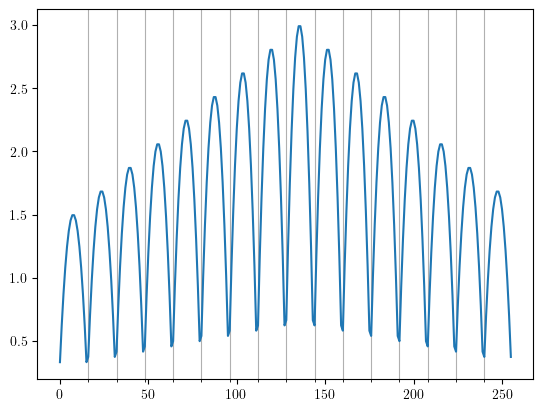

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

a = 1.0
b = 2.0
h = b-a
Nx = 2**4
slope = 2*(b-a)/Nx
f1 = np.zeros(Nx,dtype=np.float64)
f1[0:Nx//2] = slope*np.arange(Nx//2)
f1[Nx//2:Nx] = h - slope*(np.arange(Nx//2,Nx)-(Nx//2))

c = 1.5
x = np.arange(1, Nx+1)
g1 = 4.0*c/(Nx+1)**2 * ((Nx+1)*x - x**2) # Inverted Parabola with zeros at x=0 and x=Nx, with max height c at x=Nx/2

plt.plot(np.arange(Nx**2), np.kron(f1+a, g1))
plt.xticks(np.arange(0,Nx**2, Nx),minor='true')
plt.grid(True,which='minor')
plt.show()

In [2]:
from tests.heat_eqn.simulate_multidim import run_heat_eqn_simulation
from tests.heat_eqn.input_handler import ExperimentInput

import logging

logging.getLogger().setLevel(logging.INFO)

import numpy as np

expt = ExperimentInput(2, 0.01, 0.1, 0.2, np.array([4]), '2D True Square Wave zero-x periodic-y',
                'f(x,y) = 1.0', np.array([4,4]), np.array([0.1, 0.1]), [False, True],
                np.ones(2**8,dtype=np.float64))


qite_sols = run_heat_eqn_simulation(expt, True)

INFO:root:Performing initial measurements...
INFO:root:Starting QNUTE Iterations:
INFO:root:    Iteration 001


INFO:root:      Finished in 7.89 seconds.
INFO:root:    Iteration 100
INFO:root:      Finished in 1.58 seconds.
INFO:root:    Iteration 200
INFO:root:      Finished in 3.00 seconds.


In [3]:
from tests.heat_eqn.simulate_multidim import get_fourier_amplitudes, get_analytical_solution

fourier_amplitudes = get_fourier_amplitudes(expt.f0, expt.num_qbits, expt.periodic_bc_flag)
Nx = 2**expt.num_qbits
L = np.zeros(expt.num_space_dims,dtype=np.float64)
for j in range(expt.num_space_dims):
    L[j] = (Nx[j] + (1 if not expt.periodic_bc_flag[j] else 0))*expt.dx[j]
min_dx = np.min(expt.dx)
dt = expt.dtau * min_dx**2
Nt = np.int32(np.ceil(expt.T / dt))
analytical_sol = get_analytical_solution(fourier_amplitudes, expt.num_qbits, expt.periodic_bc_flag, expt.dx, L, Nt, dt, expt.alpha)

(1, 201, 256)


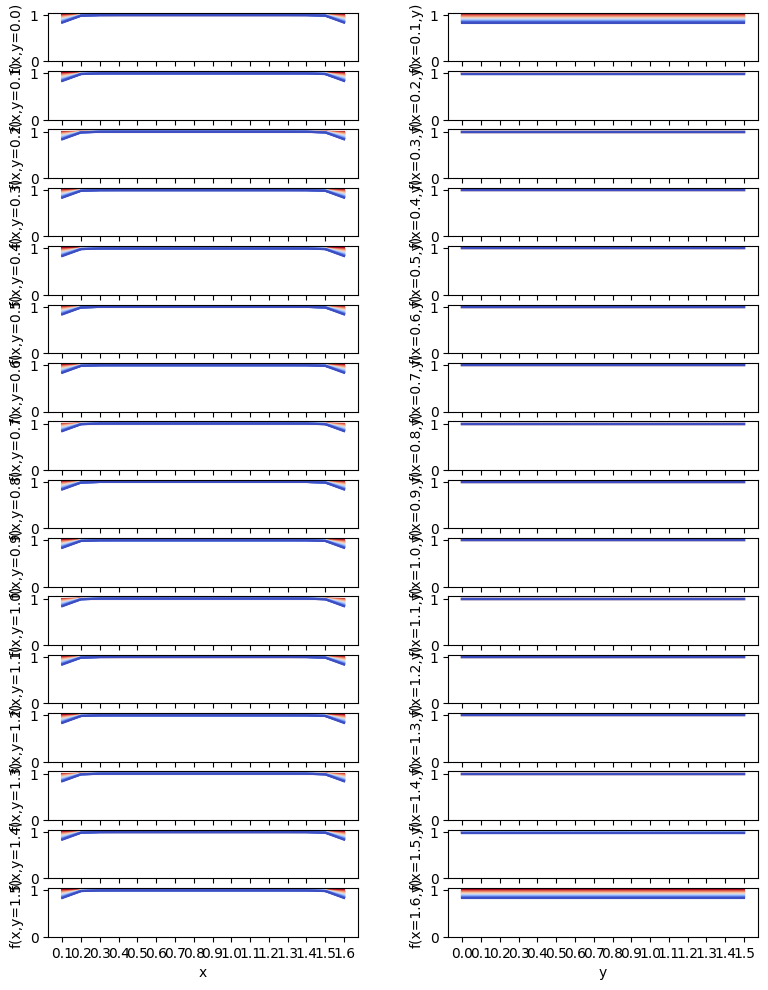

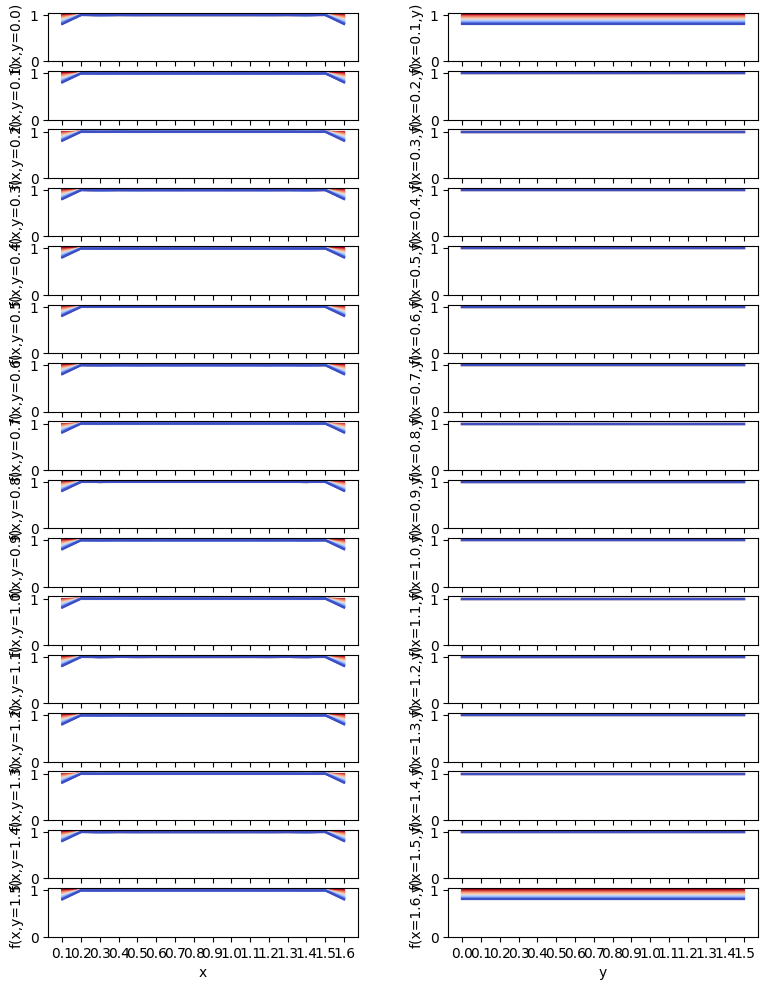

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print(qite_sols.shape)

from matplotlib import colormaps
time_colormap = colormaps.get_cmap('coolwarm').reversed()

def plot_2d_sols(expt:ExperimentInput, sols, skip:int=20, title:str='', ylim:list=None):
    Nx = 2**expt.num_qbits
    Nt = sols.shape[0]
    fig = plt.figure(figsize=(8,12))
    # fig.suptitle(title)
    skip_size = Nt//20

    fig1, fig2 = fig.subfigures(1,2, width_ratios=(1,1))

    axs = fig1.subplots(Nx[1], 1, sharex=True, sharey=True)

    xrange = np.arange(Nx[0])*expt.dx[0] if expt.periodic_bc_flag[0] else np.arange(1,Nx[0]+1)*expt.dx[0]
    for i in range(Nx[1]):
        ax = axs[i]
        ax.set_xticks(xrange)
        ax.set_ylabel(f'f(x,y={(i + (1 if not expt.periodic_bc_flag[1] else 0))*expt.dx[1]:0.1f})')
        if ylim is not None:
            ax.set_ylim(ylim)
        if (i == Nx[1] - 1):
            ax.set_xlabel('x')
        for t in range(0,Nt,skip_size):
            ax.plot(xrange, sols[t,Nx[0]*i:Nx[0]*(i+1)], color=time_colormap(t/Nt))

    axs = fig2.subplots(Nx[0], 1, sharex=True, sharey=True)
    yrange = np.arange(Nx[1])*expt.dx[1] if expt.periodic_bc_flag[1] else np.arange(1,Nx[1]+1)*expt.dx[1]
    for i in range(Nx[0]):
        ax = axs[i]
        ax.set_xticks(yrange)
        ax.set_ylabel(f'f(x={(i + (1 if not expt.periodic_bc_flag[0] else 0))*expt.dx[0]:0.1f},y)')
        if ylim is not None:
            ax.set_ylim(ylim)
        if (i == Nx[0] - 1):
            ax.set_xlabel('y')
        for t in range(0,Nt,skip_size):
            ax.plot(yrange, sols[t,i::Nx[0]], color=time_colormap(t/Nt))

    plt.show()

for Di,D in enumerate(expt.D_list):
    plot_2d_sols(expt, qite_sols[Di,:,:],title=f'{D = }', ylim=[0,1.05])

plot_2d_sols(expt, analytical_sol, title='Analytical Solution', ylim=[0,1.05])

In [10]:
%load_ext autoreload
%autoreload 2

In [33]:
qite_solutions = qite_sols
analytical_solution = analytical_sol
from tests.heat_eqn.save_experiments import save_experiment_data, load_experiment_data

fidelities = np.zeros((len(expt.D_list), Nt+1), dtype=np.float64)
log_norm_ratios = np.zeros(fidelities.shape, dtype=np.float64)
mean_sq_err = np.zeros(fidelities.shape, dtype=np.float64)

times = np.arange(Nt+1)*dt

filepath = 'data/heat_eqn/'
figpath = 'figs/heat_eqn/'

for Di,D in enumerate(expt.D_list):
    for ti,t in enumerate(times):
        fidelities[Di,ti] = np.abs(np.vdot(qite_solutions[Di,ti,:], analytical_solution[ti,:])) / (np.linalg.norm(analytical_solution[ti,:]) * np.linalg.norm(qite_solutions[Di,ti,:]))
        log_norm_ratios[Di,ti] = np.log(np.linalg.norm(analytical_solution[ti,:])) - np.log(np.linalg.norm(qite_solutions[Di,ti,:]))
        mean_sq_err[Di,ti] = np.mean((analytical_solution[ti,:] - qite_solutions[Di,ti,:])**2)

save_experiment_data(expt.num_qbits, expt.alpha, expt.dx, L, 
                        expt.dtau, Nt, expt.periodic_bc_flag,
                        analytical_solution[0,:], fourier_amplitudes,
                        qite_solutions,analytical_solution,expt.D_list,
                        fidelities,log_norm_ratios,mean_sq_err,
                        filepath=filepath,
                        filename=expt.expt_name,
                        info_string=expt.expt_info)

expt_data = load_experiment_data(filepath=filepath,filename=expt.expt_name)

INFO:QITE Heat Logger:Saved data in data/heat_eqn/2D True Square Wave zero-x periodic-y.hdf5


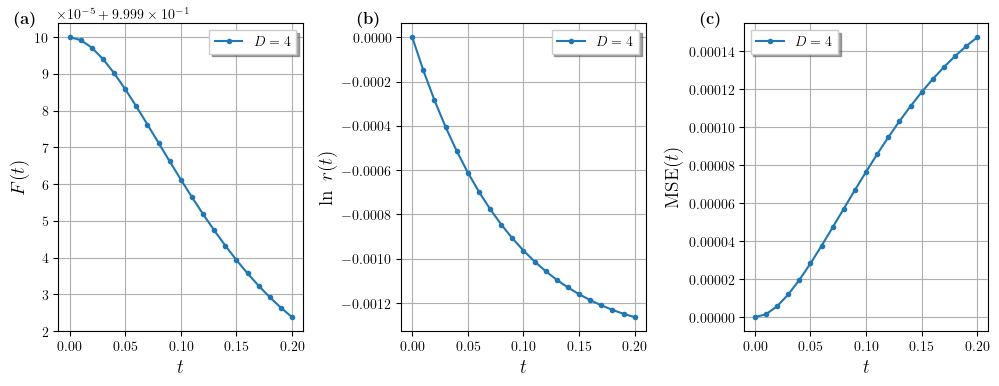

In [38]:
from tests.heat_eqn.plotting import generate_stats_figure
generate_stats_figure(expt_data, figpath=figpath, figname=expt.expt_name)

In [28]:
fidelities.shape

(1, 201)

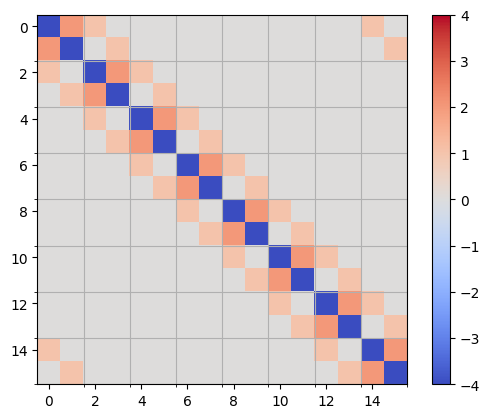

In [34]:
import numpy as np
from tests.heat_eqn.simulate_multidim import *
import matplotlib.pyplot as plt
%matplotlib inline

ndims = 2
num_qbits = np.array([1,3])
Nx = 2**num_qbits
peridic_bc_flags = np.array([True,True])
dx = np.array([0.1,0.1],np.float64)
L = np.zeros(ndims,np.float64)
for j in range(ndims):
    if not peridic_bc_flags[j]:
        L[j] = (Nx[j]+1)*dx[j]
    else:
        L[j] = Nx[j]*dx[j]
Nt = 3
dt = 0.1
alpha = 0.1

N = np.prod(Nx)

from qnute.hamiltonian.laplacian import generateLaplacianHamiltonianMultiDim
Lap = generateLaplacianHamiltonianMultiDim(num_qbits, dx, peridic_bc_flags)

plt.imshow(M:=Lap.get_matrix().real,
           cmap='coolwarm',
           vmin=-np.max(np.abs(M)),vmax=np.max(np.abs(M))
           )
plt.xticks(np.arange(Nx[0]-0.5, N, Nx[0]),minor='true')
plt.yticks(np.arange(Nx[0]-0.5, N, Nx[0]),minor='true')
plt.grid(True,which='minor')
plt.colorbar()
plt.show()

In [ ]:


# psi = np.random.uniform(0,1,N)
psi = np.ones(N)
# psi /= np.linalg.norm(psi)


fourier_amps = get_fourier_amplitudes(psi, num_qbits, peridic_bc_flags)
# fourier_amps = np.array([1.0/i for i in range(1,N+1)], dtype=np.float64)

print(fourier_amps)
f = np.zeros(N)
for i, (state,factor,freqs) in enumerate(get_fourier_eigenstates(num_qbits, peridic_bc_flags)):
    f += fourier_amps[i] * state

analytical_sols = get_analytical_solution(fourier_amps, num_qbits, peridic_bc_flags, dx, L, Nt, dt, alpha)

# # plt.plot(np.arange(N), psi)
# plt.plot(np.arange(N), f)
# plt.show()

fig = plt.figure(figsize=(8,8))

fig1, fig2 = fig.subfigures(1,2, width_ratios=(1,1))

axs = fig1.subplots(Nx[1], 1, sharex=True, sharey=True)

xrange = np.arange(Nx[0])*dx[0] if peridic_bc_flags[0] else np.arange(1,Nx[0]+1)*dx[0]
for i in range(Nx[1]):
    ax = axs[i]
    ax.set_xticks(xrange)
    ax.set_ylabel(f'f(x,y={(i + (1 if not peridic_bc_flags[1] else 0))*dx[1]:0.1f})')
    if (i == Nx[1] - 1):
        ax.set_xlabel('x')
    for t in range(Nt+1):
        ax.plot(xrange, analytical_sols[t,Nx[0]*i:Nx[0]*(i+1)])

axs = fig2.subplots(Nx[0], 1, sharex=True, sharey=True)
yrange = np.arange(Nx[1])*dx[1] if peridic_bc_flags[1] else np.arange(1,Nx[1]+1)*dx[1]
for i in range(Nx[0]):
    ax = axs[i]
    ax.set_xticks(yrange)
    ax.set_ylabel(f'f(x={(i + (1 if not peridic_bc_flags[0] else 0))*dx[0]:0.1f},y)')
    if (i == Nx[0] - 1):
        ax.set_xlabel('y')
    for t in range(Nt+1):
        ax.plot(yrange, analytical_sols[t,i::Nx[0]])

plt.show()

In [1]:
from qnute.hamiltonian import (Hamiltonian, 
                               get_identity_hm_list, 
                               hm_list_sum, 
                               hm_list_tensor)
from qnute.hamiltonian.laplacian import (get_laplace1D_hm_list, 
                                         get_laplace1D_periodic_hm_list, 
                                         laplaceKernel_hm_list, 
                                         lowerLeftKernel_hm_list, 
                                         lowerRightKernel_hm_list,
                                         upperLeftKernel_hm_list, 
                                         upperRightKernel_hm_list,
                                         generateLaplaceHamiltonian1D)
import numpy as np
l2 = get_laplace1D_hm_list(2)
# print(l2)
L2 = Hamiltonian(l2,2)
# print(L2)
# print(L2.get_matrix().real)

def print_hm_list(h,title:str=''):
    print(title)
    for hm in h:
        print('  ',hm)

i1 = get_identity_hm_list(1)

l2r = Hamiltonian.reduce_hm_list(l2,2)
print_hm_list(l2)
print_hm_list(l2r)
print_hm_list(hm_list_tensor(i1, l2),'original')
print_hm_list(il2r:=hm_list_tensor(i1, l2r), 'reduced')

print_hm_list(Hamiltonian.reduce_hm_list(il2r, 3),'reduced again')


   [array([ 1,  0,  5, 10], dtype=uint32), array([ 1. +0.j, -2. +0.j,  0.5+0.j,  0.5-0.j]), array([0, 1])]

   [array([1], dtype=uint32), array([1.+0.j]), array([0], dtype=uint32)]
   [array([ 5, 10,  0], dtype=uint32), array([ 0.5+0.j,  0.5-0.j, -2. +0.j]), array([0, 1], dtype=uint32)]
original
   [array([ 1,  0,  5, 10], dtype=uint32), array([ 1. +0.j, -2. +0.j,  0.5+0.j,  0.5+0.j]), array([0, 1, 2])]
reduced
   [array([1], dtype=uint32), array([1.+0.j]), array([0, 2], dtype=int64)]
   [array([ 5, 10,  0], dtype=uint32), array([ 0.5+0.j,  0.5+0.j, -2. +0.j]), array([0, 1, 2], dtype=int64)]
reduced again
   [array([1], dtype=uint32), array([1.+0.j]), array([0], dtype=uint32)]
   [array([ 5, 10], dtype=uint32), array([0.5+0.j, 0.5+0.j]), array([0, 1], dtype=uint32)]
   [array([0], dtype=uint32), array([-2.+0.j]), array([0, 1, 2], dtype=uint32)]


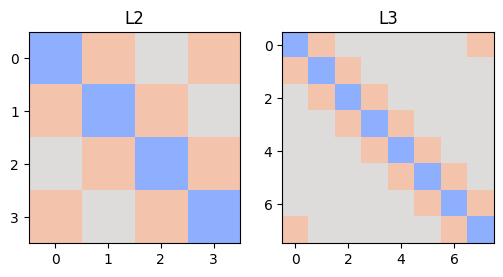

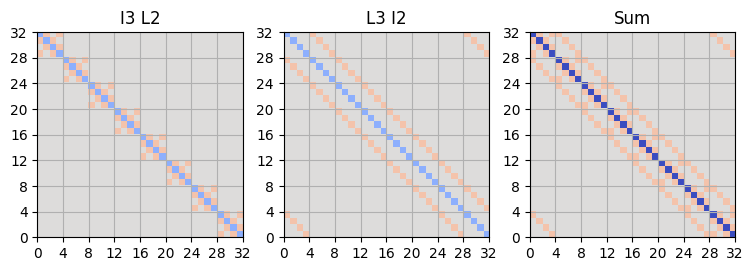

In [2]:
from qnute.hamiltonian.laplacian import generateLaplaceHamiltonian1D
L2 = generateLaplaceHamiltonian1D(2,periodic_bc_flag=True)
L3 = generateLaplaceHamiltonian1D(3,periodic_bc_flag=True)

import matplotlib.pyplot as plt
%matplotlib inline

fig,axs = plt.subplots(1,2,figsize=(6,3))
axs[0].imshow(L2.get_matrix().real, cmap='coolwarm',vmin=-4,vmax=4)
axs[0].set_title('L2')
axs[1].imshow(L3.get_matrix().real, cmap='coolwarm',vmin=-4,vmax=4)
axs[1].set_title('L3')
plt.show()
# axs[0].imshow(L2.get_matrix(), cmap='coolwarm',vmin=-4,vmax=4)

I2 = Hamiltonian(get_identity_hm_list(2),2)
I3 = Hamiltonian(get_identity_hm_list(3),3)

fig,axs = plt.subplots(1,3,figsize=(9,3))
I3L2 = Hamiltonian.tensor_product(I3,L2)
L3I2 = Hamiltonian.tensor_product(L3,I2)
lap = I3L2 + L3I2
axs[0].imshow(I3L2.get_matrix().real, cmap='coolwarm',vmin=-4,vmax=4,extent=[0,32,0,32])
axs[1].imshow(L3I2.get_matrix().real, cmap='coolwarm',vmin=-4,vmax=4,extent=[0,32,0,32])
axs[2].imshow(lap.get_matrix().real, cmap='coolwarm',vmin=-4,vmax=4,extent=[0,32,0,32])

sep = 4

for ax in axs:
    # ax.set_xticks(np.arange(sep,32,sep),minor='True')
    # ax.set_yticks(np.arange(sep,32,sep),minor='True')
    # ax.xaxis.grid(True,which='minor')
    # ax.yaxis.grid(True,which='minor')
    ax.set_xticks(np.arange(0,32+1,sep))
    ax.set_yticks(np.arange(0,32+1,sep))
    ax.grid(True)

axs[0].set_title('I3 L2')
axs[1].set_title('L3 I2')
axs[2].set_title('Sum')
plt.show()

In [3]:
print(lap.get_matrix().real)
eigvals,eigvecs = lap.get_spectrum()
eigvecs.T.real

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  1.  0.  0.]
 [ 0.  1. -4. ...  0.  1.  0.]
 ...
 [ 0.  1.  0. ... -4.  1.  0.]
 [ 0.  0.  1. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]]


array([[ 0.1767767 ,  0.1767767 ,  0.1767767 , ...,  0.1767767 ,
         0.1767767 ,  0.1767767 ],
       [-0.25      , -0.25      , -0.25      , ..., -0.1767767 ,
        -0.1767767 , -0.1767767 ],
       [-0.19754247, -0.19754247, -0.19754247, ..., -0.24802792,
        -0.24802792, -0.24802792],
       ...,
       [ 0.00109265, -0.00109265,  0.00109265, ...,  0.17754763,
        -0.17754763,  0.17754763],
       [ 0.25      , -0.25      ,  0.25      , ...,  0.1767767 ,
        -0.1767767 ,  0.1767767 ],
       [-0.1767767 ,  0.1767767 , -0.1767767 , ..., -0.1767767 ,
         0.1767767 , -0.1767767 ]])

In [4]:
print_hm_list(I3L2.hm_list, 'I3L2')
print_hm_list(L3I2.hm_list, 'L3I2')
print_hm_list(hm_list_sum(I3L2.hm_list, L3I2.hm_list), 'sum')

I3L2
   [array([1], dtype=uint32), array([1.+0.j]), array([0], dtype=uint32)]
   [array([5], dtype=uint32), array([1.+0.j]), array([0, 1], dtype=uint32)]
   [array([0], dtype=uint32), array([-2.+0.j]), array([0, 1, 2, 3, 4], dtype=uint32)]
L3I2
   [array([1], dtype=uint32), array([1.+0.j]), array([2], dtype=uint32)]
   [array([ 5, 10], dtype=uint32), array([0.5+0.j, 0.5+0.j]), array([2, 3], dtype=uint32)]
   [array([21, 26], dtype=uint32), array([ 0.5+0.j, -0.5+0.j]), array([2, 3, 4], dtype=uint32)]
   [array([0], dtype=uint32), array([-2.+0.j]), array([0, 1, 2, 3, 4], dtype=uint32)]
sum
   [array([0], dtype=uint32), array([-4.+0.j]), array([0, 1, 2, 3, 4], dtype=uint32)]
   [array([1], dtype=uint32), array([1.+0.j]), array([0], dtype=uint32)]
   [array([5], dtype=uint32), array([1.+0.j]), array([0, 1], dtype=uint32)]
   [array([1], dtype=uint32), array([1.+0.j]), array([2], dtype=uint32)]
   [array([ 5, 10], dtype=uint32), array([0.5+0.j, 0.5+0.j]), array([2, 3], dtype=uint32)]
   [ar

**Get the Fourier Amplitudes of a multi dimensional Laplacian operator**

In [149]:
def get_fourier_eigenstates(num_qbits:np.ndarray[int],
                            periodic_bc_flags:np.ndarray[bool]):
    ndim = num_qbits.shape[0]
    Nx = 2**num_qbits
    num_freq = 2**(np.sum(num_qbits))
    

    state_counter = np.zeros(ndim,dtype=np.int32)

    for i in range(num_freq):
        # Get eigenstate:
        eigenstate = np.array([1],dtype=np.float64)
        normalization = 1.0
        frequencies = np.zeros(ndim,dtype=np.int32)

        for j in range(ndim):
            if not periodic_bc_flags[j]:
                x = np.arange(1,Nx[j]+1)
                nu = state_counter[j] + 1
                eigenstate = np.kron(np.sin(nu*np.pi*x/(Nx[j]+1)), eigenstate)
                normalization *= (Nx[j]+1)/2.0
            else:
                x = np.arange(Nx[j])
                if state_counter[j] == 0:
                    nu = 0
                    eigenstate = np.kron(np.ones(Nx[j]), eigenstate)
                    normalization *= Nx[j]
                elif state_counter[j] % 2 == 0:
                    nu = state_counter[j]
                    eigenstate = np.kron(np.sin(nu*np.pi*x/Nx[j]), eigenstate)
                    normalization *= Nx[j]/2.0
                else:
                    nu = state_counter[j] + 1
                    eigenstate = np.kron(np.cos(nu*np.pi*x/Nx[j]), eigenstate)
                    if nu != Nx[j]:
                        normalization *= Nx[j]/2.0
                    else:
                        normalization *= Nx[j]
            frequencies[j] = nu
            
        yield eigenstate,normalization,frequencies
        
        # update state counter
        for j in range(ndim):
            state_counter[j] += 1
            if state_counter[j] != Nx[j]:
                break
            else:
                state_counter[j] = 0

ndims = 2
num_qbits = np.array([2,3])
dx = np.array([1.0,1.0])
periodic_bc_flags = np.array([True,True])
L = np.ones(2,dtype=np.float64)
for j in range(ndims):
    L[j] = (2**num_qbits[j] + (1 if not periodic_bc_flags[j] else 0)) * dx[j]

print(f'{L = }')

for state,factor,freqs in get_fourier_eigenstates(num_qbits, periodic_bc_flags):
    print(freqs)

L = array([4., 8.])
[0 0]
[2 0]
[2 0]
[4 0]
[0 2]
[2 2]
[2 2]
[4 2]
[0 2]
[2 2]
[2 2]
[4 2]
[0 4]
[2 4]
[2 4]
[4 4]
[0 4]
[2 4]
[2 4]
[4 4]
[0 6]
[2 6]
[2 6]
[4 6]
[0 6]
[2 6]
[2 6]
[4 6]
[0 8]
[2 8]
[2 8]
[4 8]


In [16]:
2**np.sum(num_qbits)

32

(32, 32)


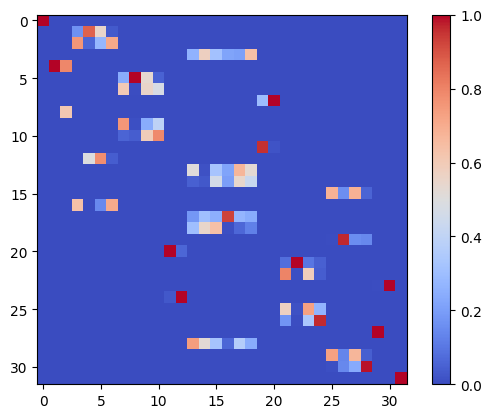

In [43]:
psi = np.ones(16,dtype=np.float64) / np.sqrt(16)

gen = get_fourier_eigenstates(num_qbits, dx, periodic_bc_flags, L)

N = 2**(np.sum(num_qbits))
dot = np.zeros( (N,N) , dtype=np.float64)

print(dot.shape)
for i, (state,factor) in enumerate(gen):
    # print(i, state.shape)
    for j, vec in enumerate(eigvecs.T):
        # print(j, vec.shape)
        dot[i,j] = np.abs(np.dot(state, vec)/(np.linalg.norm(state)*np.linalg.norm(vec)))

# print(dot)

plt.imshow(dot, cmap='coolwarm')
plt.colorbar()

[-1.15727117e-16 -5.85786438e-01 -5.85786438e-01 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00 -2.00000000e+00 -2.58578644e+00
 -2.58578644e+00 -2.58578644e+00 -2.58578644e+00 -3.41421356e+00
 -3.41421356e+00 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00
 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00 -4.58578644e+00
 -4.58578644e+00 -5.41421356e+00 -5.41421356e+00 -5.41421356e+00
 -5.41421356e+00 -6.00000000e+00 -6.00000000e+00 -6.00000000e+00
 -6.00000000e+00 -7.41421356e+00 -7.41421356e+00 -8.00000000e+00]


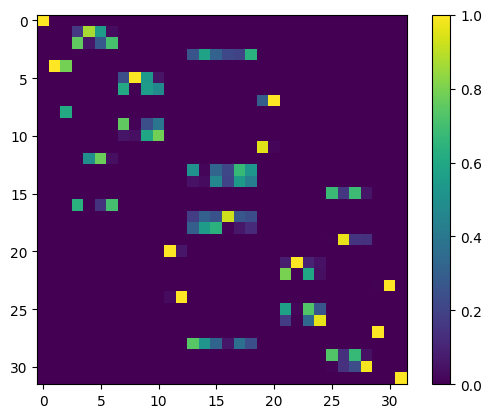

In [74]:
M = lap.get_matrix().real
eigvals, eigvecs = lap.get_spectrum()

x2 = np.arange(0,4)
x3 = np.arange(0,8)

dot = np.zeros((32,32))

print(eigvals.real)

for i, (psi, factor) in enumerate(get_fourier_eigenstates(np.array([2,3]), np.array([True,True]))):
    for j, phi in enumerate(eigvecs.T):
        dot[i,j] = np.abs(np.dot(psi, phi))/np.linalg.norm(psi)

plt.imshow(dot)
plt.colorbar()


    

In [211]:
N=4
psi = np.random.uniform(0,1,N)
psi /= np.linalg.norm(psi)
# print(psi)

def count_state(count, ndim, Nx):
    state_counter = np.zeros(ndim,dtype=np.int32)
    for i in range(count):
        for j in range(ndim):
            state_counter[j] += 1
            if state_counter[j] != Nx[j]:
                break
            else:
                state_counter[j] = 0
    return state_counter

def get_fourier_amplitudes(psi, num_qbits, periodic_bc_flags):
    amplitudes = np.zeros(psi.shape[0], dtype=np.dtype([('amplitude', np.float64), ('frequencies', np.int32, (num_qbits.shape[0],))]))
    for i, (state,factor,freqs) in enumerate(get_fourier_eigenstates(num_qbits, periodic_bc_flags)):
        amplitudes[i]['amplitude'] = np.dot(state, psi) / factor
        amplitudes[i]['frequencies'] = freqs
    return amplitudes
        

psi2 = np.zeros(N)
ndif = np.zeros(N)
# for i, (state, factor,freqs) in enumerate(get_fourier_eigenstates(np.array([2]), np.array([True]))):
#     psi2 += np.dot(state, psi) * state / factor
#     (i, a:=1/factor, b:=1/np.linalg.norm(state)**2, np.abs(a-b))
#     ndif[i] = np.abs(a-b)
#     if True:
#         # print(f'index {i = } does not match')
#         print(count_state(i, 1, [4]))

amps = get_fourier_amplitudes(psi, np.array([2]), np.array([True]))

for i, (state,norm,freqs) in enumerate(get_fourier_eigenstates(np.array([2]), np.array([True]))):
    psi2 += amps[i]['amplitude'] * state

# plt.plot(np.arange(N), psi)
# plt.plot(np.arange(N), psi2)
# # plt.scatter(np.arange(N), ndif)
# plt.xticks(np.arange(0,N,4))
# plt.xticks(np.arange(N),minor='true')
# # plt.yticks(np.arange(0.0,0.1, 0.01))
# plt.ylim([0,1])
# plt.grid(True, which='both')
# plt.show()

num_qbits = 2
Nx = 2**num_qbits
dx = 100_000
L = Nx * dx
Lap = generateLaplaceHamiltonian1D(num_qbits, dx, True, False)
M = Lap.get_matrix().real

from qnute.helpers import exp_mat_psi
dt = 1.0
th = exp_mat_psi(M*dt, psi)
print(M)
print(th)


psi3 = np.zeros(Nx)
for i, (state,factor,_freqs) in enumerate(get_fourier_eigenstates(np.array([2]), np.array([True]))):
    amp = amps[i]['amplitude']
    freqs = amps[i]['frequencies']
    k = 0.0
    for j in range(1):
        k += (np.pi*freqs[j]/L)**2
    # print(i, k)
    psi3 += amp*np.exp(-k*dt)*state

print(th)
print(psi3)

[[-50.  25.   0.  25.]
 [ 25. -50.  25.   0.]
 [  0.  25. -50.  25.]
 [ 25.   0.  25. -50.]]
[-2.00487539e+25  2.00487539e+25 -2.00487539e+25  2.00487539e+25]
[-2.00487539e+25  2.00487539e+25 -2.00487539e+25  2.00487539e+25]
[0.4775482  0.01097604 0.72445614 0.49698143]


In [56]:
x = np.arange(1,5)*dx[0]
print(ten:=np.kron(np.sin(np.pi*x/L[0]), np.sin(np.pi*x/L[0])))
print(np.linalg.norm(ten)**2)

[0.3454915  0.55901699 0.55901699 0.3454915  0.55901699 0.9045085
 0.9045085  0.55901699 0.55901699 0.9045085  0.9045085  0.55901699
 0.3454915  0.55901699 0.55901699 0.3454915 ]
6.25


In [58]:
factor/np.prod(dx)

6.249999999999999

In [49]:
factor

0.0625